In [1]:
from matplotlib import pyplot as plt
import numpy as np
import skimage, skimage.morphology, skimage.feature
%matplotlib inline

Computes a homogeneous line vector from the $\rho$, $\theta$ parameters returned by SKImage's Hough transform

In [2]:
def homline(rho, theta):
    return [np.cos(theta), np.sin(theta), -rho]

Returns intersection of two homogeneous lines

**TODO:** Points at the infinity are not handled properly

In [3]:
def homintersect(l1, l2):
    p = np.cross(l1, l2)
    p = p/p[2]
    return p

Produces an image of the same shape given as second parameter, representing the geometrical locus of the predicate in the first parameter: the image is 1 if the predicate holds, 0 otherwise.

In [4]:
def locus_imshape(pred, shape):
    return np.array([[1.0 if pred(x, y) else 0.0 for x in range(0, shape[1])] for y in range(0, shape[0])])

In [5]:
def find_table(pic):
    hsvpic = skimage.color.rgb2hsv(pic)
    bwpic = hsvpic[:,:,2]
    bwpic = bwpic/np.max(bwpic)
    
    # The histogram should be somehow U-shaped, so the threshold is computed by taking
    # density maximum above the mean, and then stepping back by a certain proportion of
    # the standard deviation.
    density, edges = np.histogram(bwpic.flat, bins = 40)
    mean = np.mean(bwpic)
    sigma = np.std(bwpic)
    stepback = 0.5
    split = np.searchsorted(edges, mean, side='right')
    maxd = split + np.argmax(density[split:])
    threshold = edges[maxd] - stepback*sigma
    maskpic = bwpic > threshold
    
    # The largest connected region will be selected at the table.
    # In order to disconnect nearby bright background region, Canny edges computed on
    # the hue channel (hue is chosen because we already know there wasn't enough distance
    # in brightness).
    huepic = hsvpic[:,:,0]
    cannyhue = skimage.feature.canny(huepic, sigma=8)
    huemask = ~cannyhue & maskpic
    labeledpic = skimage.measure.label(huemask)
    largestmask = labeledpic == np.argmax(np.bincount(labeledpic.flat)[1:])+1
    
    # A closure is computed on the mask to clean out speckles and dirt. 
    disk = skimage.morphology.disk(8)
    return skimage.morphology.binary_closing(largestmask, selem=disk)

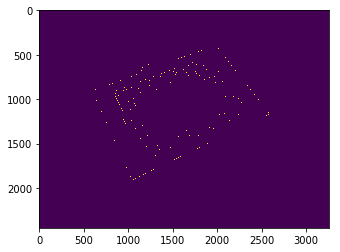

In [19]:
pic = plt.imread("pics2/01.jpg")

tablemask = find_table(pic)
cannypic = skimage.feature.canny(tablemask)
plt.figure('canny')
plt.imshow(cannypic)

In [20]:
hres = skimage.transform.hough_line(cannypic)
threshold = 0.1*np.max(hres[0])
_, angles, dists = skimage.transform.hough_line_peaks(*hres, num_peaks=4, threshold=threshold, min_distance=100)

lines = [homline(rho, theta) for rho, theta in zip(dists, angles)]
assert(len(lines) == 4), f"Should be 4 lines, not {len(lines)}!"

Vanishing points are found by assuming that the lines with the closest angles are images of parallel lines.

**TODO:** Verify that the assumption is formally valid.

array([[ 7.43533030e+03, -1.59849361e+03,  1.00000000e+00],
       [-2.02228832e+03, -4.80422111e+03,  1.00000000e+00]])

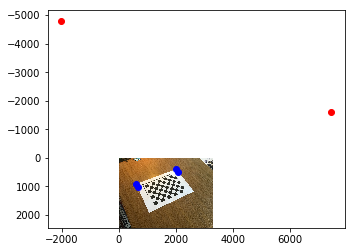

In [21]:
# The angle space should be continuous between -pi/2 and pi/2, so we throw the antipodal angles into the mix
# The indices will be restored by modding by 4
angles_xt = list(enumerate(np.concatenate((angles, angles+np.pi))))
angle_cpls = [((i, x), (j, y)) for i, x in angles_xt for j, y in angles_xt if i<j]
# The angles are the second elements of each (i, x) tuple in the couple
mindstcpl = min(angle_cpls, key=lambda ix_jy: abs(ix_jy[0][1]-ix_jy[1][1]))
par_idcs1 = [mindstcpl[0][0]%4, mindstcpl[1][0]%4]
par_idcs2 = [i for i in range(4) if i not in par_idcs1]

# Not very elegant, I know
vp1 = homintersect(lines[par_idcs1[0]], lines[par_idcs1[1]])
vp2 = homintersect(lines[par_idcs2[0]], lines[par_idcs2[1]])
intersections = np.array([homintersect(lines[i], lines[j]) for i in par_idcs1 for j in par_idcs2])

vps = np.array([vp1, vp2])

plt.figure("points")
plt.imshow(pic)
plt.plot(intersections[:,0], intersections[:,1], 'bo')
plt.plot(vps[:, 0], vps[:, 1], 'ro')
vps

In [22]:
",".join(str(f) for f in vps.flat)

'7435.330302122824,-1598.4936100606922,1.0,-2022.2883244417092,-4804.2211067048775,1.0'